In [1]:
# !pip install highway-env
# !pip install git+https://github.com/DLR-RM/stable-baselines3
# !pip install tensorboardx gym pyvirtualdisplay
# !apt-get install -y xvfb python-opengl ffmpeg
# !git clone https://github.com/eleurent/highway-env.git 2> /dev/null
# !git clone https://github.com/avivg7/highway-config.git
# !pip install tensorboard
# !pip install xvfbwrapper

In [2]:
from cffi import FFI
import os

ffi = FFI()
ffi.cdef("""
/* from stdio.h */
FILE* fopen(const char* path, const char* mode);
int fclose(FILE* fp);
FILE* stderr;  /* GNU C library */
FILE* __stderrp;  /* Mac OS X */
""")
try:
    stdio = ffi.dlopen(None)
    devnull = stdio.fopen(os.devnull.encode(), b'w')
except OSError:
    pass
try:
    stdio.stderr = devnull
except KeyError:
    try:
        stdio.__stderrp = devnull
    except KeyError:
        stdio.fclose(devnull)

In [3]:
# General
import sys
sys.path.insert(0, '/content/highway-env/scripts/')
import io
import base64
import os
from tqdm.notebook import trange
import numpy as np
import random
import math
import pygame
import json
import ast
from pprint import pprint 
import glob
from collections import Counter

# Local
from final_project.display_utils import wrap_env, show_video
from models.agent import Agent
from models.utils import plot_learning_curve

# Gym Env
import gym
import highway_env
# from utils import record_videos, show_videos
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Visualization
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay

%load_ext tensorboard
%matplotlib inline

pygame 2.1.2 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [5]:
# #=============== DO NOT DELETE ===============
# file = open('./highway-config/config_ex1.txt', 'r')
# contents = file.read()
# config1 = ast.literal_eval(contents)
# file.close()
# # ============================================

# env = gym.make("highway-fast-v0")
# env.configure(config1)

# obs = env.reset()
# for j in range(10):
#     obs, _, _, _ = env.step(0)

#     _, axes = plt.subplots(ncols=4, figsize=(12, 5))
#     for i, ax in enumerate(axes.flat):
#         ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
    

# env = wrap_env(env)
# env.reset()
# done = False
# iter = 0

# while (iter < 10) or not done:
#   if done:
#     break
#   iter +=1
#   action = env.action_space.sample()
#   observation, reward, done, _ = env.step(action)
#   screen = env.render(mode='rgb_array')
#   plt.imshow(screen)
#   print(f'iteration: {iter}, action: {action}, reward: {reward}, done: {done}')

In [6]:
torch.cuda.is_available()

True

In [7]:
#=============== DO NOT DELETE ===============
# file = open('/content/highway-config/config_ex1.txt', 'r')
# contents = file.read()
# config1 = ast.literal_eval(contents)
# file.close()
# ============================================

file = open('./highway-config/config_ex1.txt', 'r')
contents = file.read()
# print(contents)
config1 = ast.literal_eval(contents)
file.close()

env = gym.make("highway-fast-v0")
env.configure(config1)
# env = wrap_env(env)
env.reset()
# env.config

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[99., 99., 99., ..., 99., 99., 99.],
        [99., 99., 99., ..., 99., 99., 99.],
        [99., 99., 99., ..., 99., 99., 99.],
        ..

In [8]:
# a = np.max(observation)

# while a == 0:
#     action = env.action_space.sample()
#     observation, reward, done, _ = env.step(action)
#     a = np.max(observation)
# print(f'np.max(observation): {np.max(observation)}')
# print(f'np.min(observation): {np.min(observation)}')    
# for i in range(100):
#     action = env.action_space.sample()
#     observation, reward, done, _ = env.step(action)

#     pprint(action)
# # pprint(observation)
#     print(f'np.max(observation): {np.max(observation)}')
#     print(f'np.min(observation): {np.min(observation)}')

In [9]:
env.observation_space.shape

(4, 128, 128)

In [ ]:
n_games = 500
figure_file = 'plots/highway_500'
torch.autograd.set_detect_anomaly(True)
# print(env.observation_space.shape)
agent = Agent(input_dims=env.observation_space.shape,
              env=env,
              n_actions=5,
              max_size=10000)

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

if load_checkpoint:
    agent.load_models()
    env.render(mode='human')
    
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        new_observation, reward, done, info = env.step(action)
        score += reward
        # print(f'observation.shape: {observation.shape}')
        agent.remember(observation, action, reward, new_observation, done)
        if not load_checkpoint:
            agent.learn()
        observation = new_observation
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    
    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()
    
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    print(f'Episode: {i}, Score {score}, Average Score: {avg_score}')
    
if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)

(10000, 4, 128, 128)
4 128 128


/home/jupyter/highway-rl/models/agent.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/torch/csrc/utils/tensor_new.cpp:210.)
  state = T.Tensor([observation]).to(self.actor.device)


Episode: 0, Score 6.427488783640454, Average Score: 6.427488783640454
Episode: 1, Score 20.758340001641916, Average Score: 13.592914392641184
Episode: 2, Score 7.209223788698229, Average Score: 11.4650175246602
Episode: 3, Score 9.467986325111474, Average Score: 10.965759724773019
Episode: 4, Score 18.868174754240343, Average Score: 12.546242730666483
Episode: 5, Score 26.235703164061817, Average Score: 14.827819469565705
Episode: 6, Score 33.28756341192389, Average Score: 17.464925747045445
Episode: 7, Score 29.01027732674274, Average Score: 18.90809469450761
Episode: 8, Score 7.412351876334187, Average Score: 17.630789936932786
Episode: 9, Score 12.776462900566873, Average Score: 17.145357233296195
Episode: 10, Score 15.749940345373897, Average Score: 17.018501152575986
Episode: 11, Score 9.457712696054516, Average Score: 16.388435447865863
Episode: 12, Score 18.295431464347075, Average Score: 16.53512744913365
Episode: 13, Score 24.901650411786473, Average Score: 17.13273623218028
E

ValueError: x and y must have same first dimension, but have shapes (500,) and (38,)

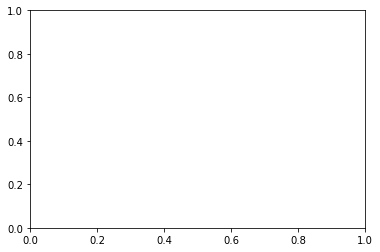

In [9]:
if not load_checkpoint:
    x = [i+1 for i in range(n_games)]
    plot_learning_curve(x, score_history, figure_file)

In [ ]:
# env.close()
# show_video()

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform(m.weight,  -3*1.e-4, 3*1.e-4)
            m.bias.data.fill_(0.0001)

class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()
        self.shared_layers = nn.Sequential( # todo: name
            nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=0),
            nn.Linear(64*12*12, 5),
        )
        self.shared_layers.apply(init_weights)

    def forward(self, x):
        input_tensor = torch.tensor(x, dtype=torch.float)
        hidden = self.shared_layers(input_tensor)
        #output = self.output(hidden)
        actions_probs = Categorical(F.softmax(hidden, dim=-1))

        return actions_probs, hidden

class CriticNet(nn.Module):
    def __init__(self):
        super(CriticNet, self).__init__()
        self.shared_layers = nn.Sequential(  # todo: name
            nn.Conv2d(4, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=0),
            nn.Linear(64 * 12 * 12, 1),
        )


    def forward(self, x):
        input_tensor = torch.FloatTensor(x)
        hidden = self.shared_layers(input_tensor)

        return hidden